# HousingAnyWhere Internship Assessment for Data Scientist postion 

## Library

In [1]:
import types
import pandas as pd
from botocore.client import Config
import ibm_boto3
import seaborn as sns
import scipy.stats as stats
import matplotlib 
import matplotlib.pyplot as plt
from sklearn.feature_selection import SelectFromModel, SelectKBest, f_classif
from sklearn.preprocessing import MinMaxScaler, RobustScaler, StandardScaler, Normalizer
from sklearn.ensemble import RandomForestClassifier


from sklearn.preprocessing import MinMaxScaler, RobustScaler, StandardScaler, Normalizer
from sklearn import preprocessing
#Feature Selection
from sklearn.feature_selection import SelectFromModel, SelectKBest, f_classif
from sklearn import model_selection

# Classifiers & Model
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

# Finding parameters
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, KFold, cross_val_score, train_test_split
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import itertools

## Data

### Raw

In [2]:
# The code was removed by Watson Studio for sharing.

In [3]:
body = client_39b9c4e14b564400a5e2a7c870ec6ec0.get_object(Bucket='housinganywhere-donotdelete-pr-lyhpiq7x2pj5yc',Key='HA_Data_Science_test.csv')['Body']
# add missing __iter__ method, so pandas accepts body as file-like object
if not hasattr(body, "__iter__"): body.__iter__ = types.MethodType( __iter__, body )

df_validation = pd.read_csv(body)


### Process data

In [4]:
print("this is the size of train data:",df_train.shape)
print("this is the size of validation data:",df_validation.shape)

this is the size of train data: (25539, 25)
this is the size of validation data: (1345, 24)


In [5]:
null_columns=df_train.columns[df_train.isnull().any()]
print("This is the size of null values in train datasets",df_train[df_train.isnull().any(axis=1)][null_columns].shape)
print(df_train[df_train.isnull().any(axis=1)][null_columns].head())

This is the size of null values in train datasets (1242, 4)
    GENDER EDUCATION_LEVEL MARITAL_STATUS DATE_OF_BIRTH
45       F             NaN        married    08/01/1981
123      F             NaN         single    04/01/1983
141      F             NaN         single    17/01/1983
188      F      university         single           NaN
250      F      university         single           NaN


In [6]:
null_columns_1=df_validation.columns[df_validation.isnull().any()]
print(df_validation[df_validation.isnull().any(axis=1)][null_columns_1].shape)
print(df_validation[df_validation.isnull().any(axis=1)][null_columns_1].head())

(70, 4)
    GENDER  EDUCATION_LEVEL MARITAL_STATUS DATE_OF_BIRTH
78       F       university        married           NaN
93       F              NaN         single    04/01/1989
102      M  graduate school         single           NaN
116      F       university        married           NaN
143      F              NaN         single    05/01/1991


In [7]:
now = pd.Timestamp('now')
def Process_data(dataframe):
    # Drop all missing row data
    dataframe=dataframe.dropna()
    
    # Convert DATE_OF_BIRTH column to datatime format 
    dataframe['DATE_OF_BIRTH']= pd.to_datetime(dataframe['DATE_OF_BIRTH'], format='%d/%m/%Y')
    
    # Calculate AGE OF CLIENT
    dataframe['DATE_OF_BIRTH']=(now - dataframe['DATE_OF_BIRTH']).astype('<m8[Y]').astype('int')
    dataframe.rename(columns={'DATE_OF_BIRTH':'AGE'}, inplace= True) 
    label=dataframe['DEFAULT PAYMENT JAN']
    dataframe.drop(labels=['DEFAULT PAYMENT JAN'], axis=1,inplace = True)
    
    # Endcode str value
    dataframe.insert(0, 'DEFAULT PAYMENT JAN', label)
    dataframe= pd.get_dummies(dataframe, columns={'GENDER','EDUCATION_LEVEL','MARITAL_STATUS'})
    return dataframe

In [8]:
df_train=Process_data(df_train)

/opt/conda/envs/DSX-Python35/lib/python3.5/site-packages/ipykernel/__main__.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/opt/conda/envs/DSX-Python35/lib/python3.5/site-packages/ipykernel/__main__.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/opt/conda/envs/DSX-Python35/lib/python3.5/site-packages/pandas/core/frame.py:3027: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-

## Exploratory Data Analysis 

## Modeling

### Feature selection

In [24]:
def feature_selection_k_best(dataframe):
    X = dataframe.iloc[:,1:]
    y = dataframe.iloc[:,0:1]
    
    feature_selector = SelectKBest(f_classif, k=int(dataframe.shape[1]/2))
    feature_selector.fit(X, y)
    test = feature_selector.transform(X)
    feature_selection_support = feature_selector.get_support()
    selected_features = X.loc[:,feature_selection_support].columns
    df_kbest = pd.DataFrame(test, columns= selected_features)
    df_kbest.insert(0,'label',y)
    
    return(df_kbest)

test_1= feature_selection_k_best(df_train)

/opt/conda/envs/DSX-Python35/lib/python3.5/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [23]:
df_train=df_train.drop_duplicates()
df_train.shape

(24297, 31)

In [38]:
test_1.insert(0,'label',df_train['DEFAULT PAYMENT JAN'])

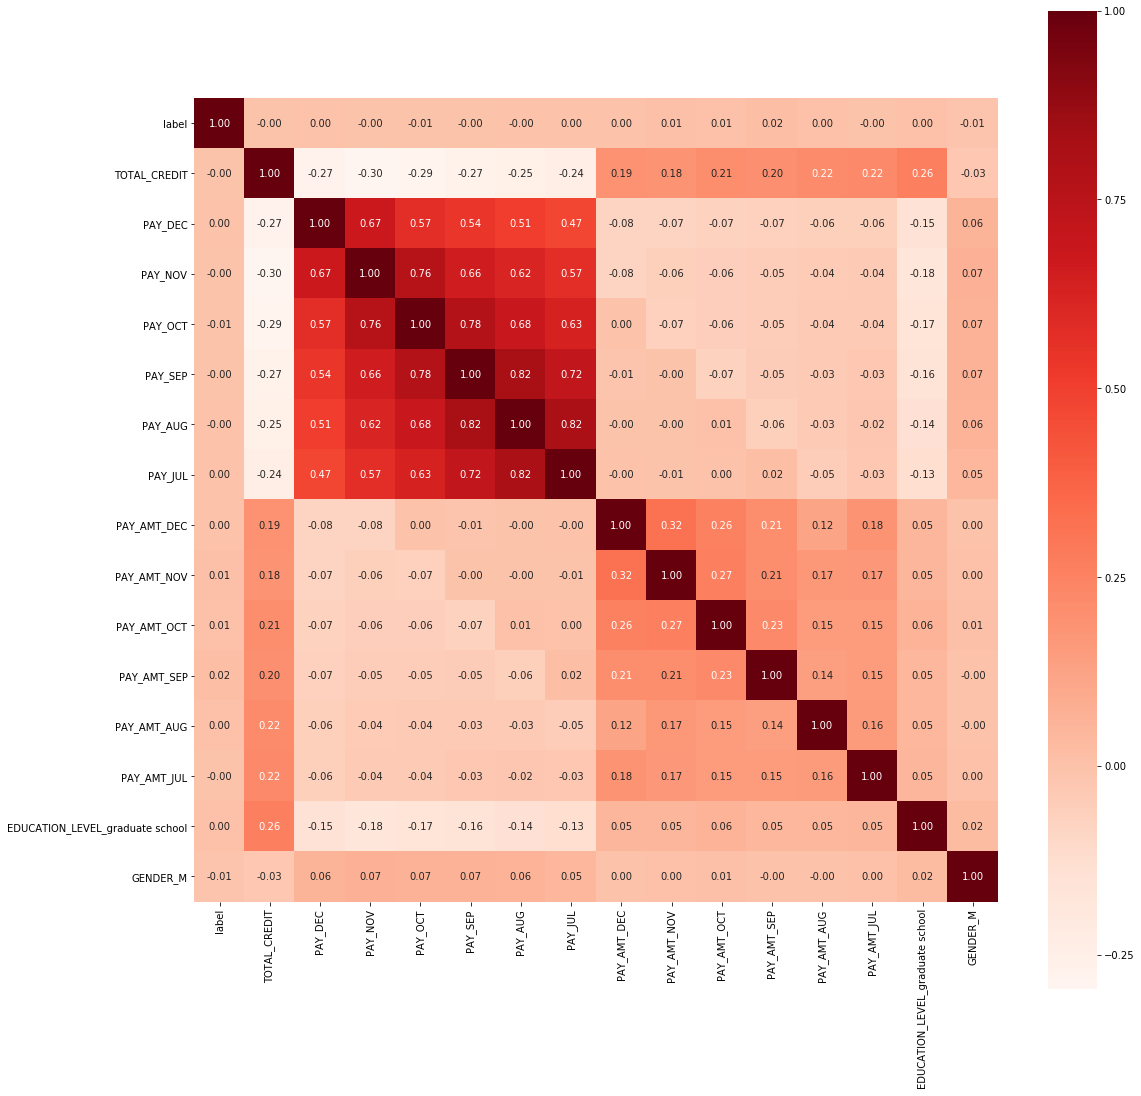

In [18]:
cor_1 = test_1.corr()
plt.figure(figsize=(18,18))
sns.heatmap(cor_1, cbar = True,  square = True, annot=True, fmt= '.2f',annot_kws={'size': 10},
            xticklabels=cor_1.columns.values,
            yticklabels=cor_1.columns.values,cmap=plt.cm.Reds)

### Pre-process 

In [12]:
models = []
results = []
names = []
predict = []

pre_processing=[]
pre_processing.append(('StandardScaler', StandardScaler()))
pre_processing.append(('Normalizer', Normalizer()))
pre_processing.append(('MinMaxScaler', MinMaxScaler()))

### Model building

In [13]:
models.append(('KNN', KNeighborsClassifier()))
models.append(('LRG', LogisticRegression()))
models.append(('CART', DecisionTreeClassifier()))
models.append(('RAND', RandomForestClassifier()))
seed =7
scoring="accuracy"

def test(data):
    X=data.iloc[:,1:]
    Y=data.iloc[:,0]     
    for test, pre in pre_processing:
        X= pre.fit_transform(X)
        X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.25, random_state=seed)
        notice="%s:" %(test)
        print(notice)
        print("")
        for name, model in models:
            kfold = model_selection.KFold(n_splits=10, random_state=7)
            cv_results = model_selection.cross_val_score(model, X_train, y_train,cv=kfold, scoring=scoring)
            results.append(cv_results)
            names.append(name)
            msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
            print("|" + msg)
        print("__________________________")

### Training

In [14]:
test(test_1)

StandardScaler:



ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

## Evaluation

## Conclusion

In [ ]:
test_1=feature_selection_k_best(dfDummies)

In [ ]:
cor = dfDummies.corr()
plt.figure(figsize=(18,18))
sns.heatmap(cor, cbar = True,  square = True, annot=True, fmt= '.2f',annot_kws={'size': 10},
            xticklabels=cor.columns.values,
            yticklabels=cor.columns.values,cmap=plt.cm.Reds)

In [ ]:
test_1=test_1.dropna()

In [35]:
output = 'DEFAULT PAYMENT JAN'
cols = [ f for f in df_train.columns if df_train.dtypes[ f ] != "object"]
cols.remove( "CLIENT_ID")
cols.remove( output )
f = pd.melt( df_train, id_vars=output, value_vars=cols)

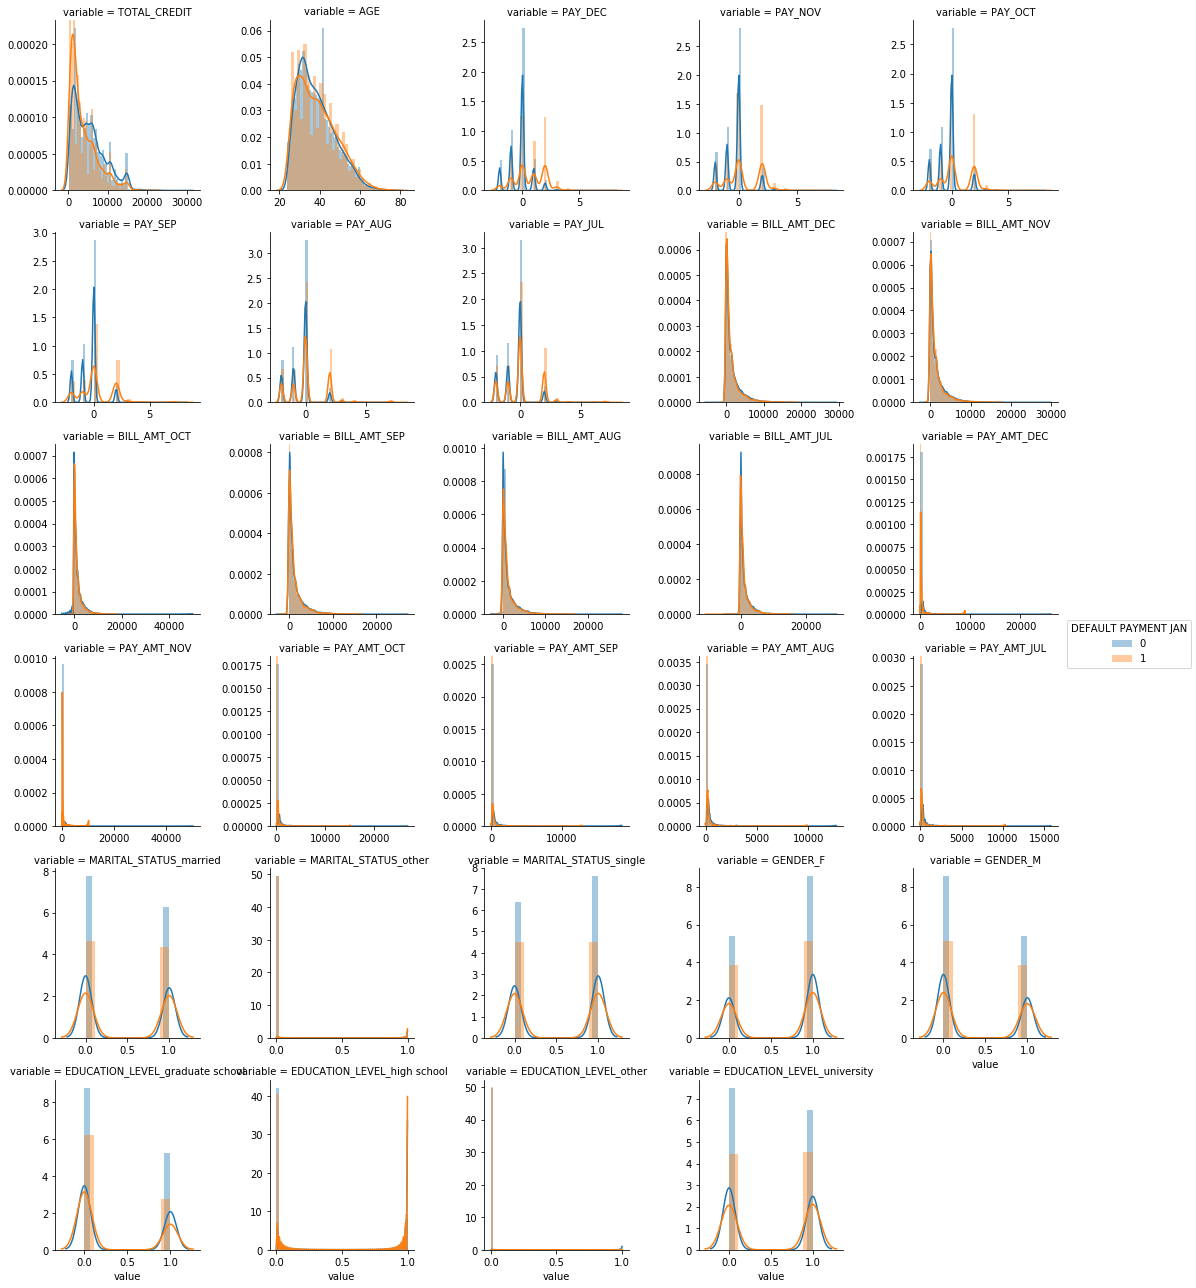

In [37]:
g = sns.FacetGrid( f, hue=output, col="variable", col_wrap=5, sharex=False, sharey=False )
g = g.map( sns.distplot, "value", kde=True).add_legend()